In [1]:
from obspy import read

# Load the mseed file
stream = read("XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed")
print(stream)


1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples


In [15]:
for trace in stream:
    print(trace.stats)

         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-01-02T04:00:00.025000Z
         endtime: 2022-01-02T05:00:00.015000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 360000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})
      processing: ["ObsPy 1.4.1: filter(options={'freqmin': 0.1, 'freqmax': 10}::type='bandpass')", "ObsPy 1.4.1: resample(no_filter=True::sampling_rate=100::strict_length=False::window='hann')"]


In [3]:
for trace in stream:
    data = trace.data  # Waveform velocities
    timestamps = trace.times("timestamp")  # Timestamps
    print(data, timestamps)


[0.         0.00050274 0.00363453 ... 0.00204673 0.00055484 0.        ] [1.6410960e+09 1.6410960e+09 1.6410960e+09 ... 1.6410996e+09 1.6410996e+09
 1.6410996e+09]


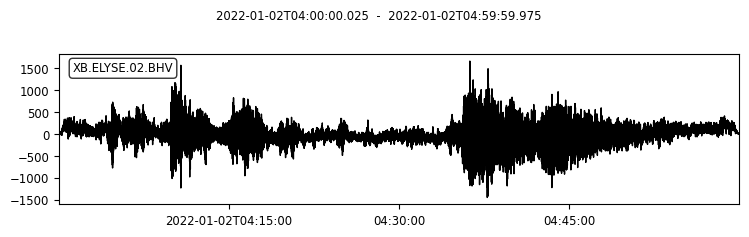

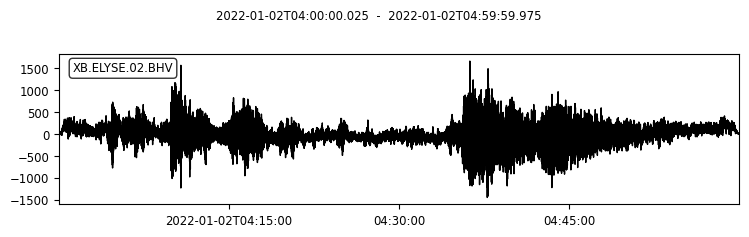

In [4]:
import matplotlib.pyplot as plt

trace = stream[0]  # Selecting the first trace
trace.plot()  # Quick visualization


In [5]:
# Apply a bandpass filter
trace.filter("bandpass", freqmin=0.1, freqmax=10)


/opt/anaconda3/lib/python3.12/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (10) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples

In [6]:
trace.resample(sampling_rate=100)


XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T05:00:00.015000Z | 100.0 Hz, 360000 samples

In [7]:
amplitude = abs(trace.data)


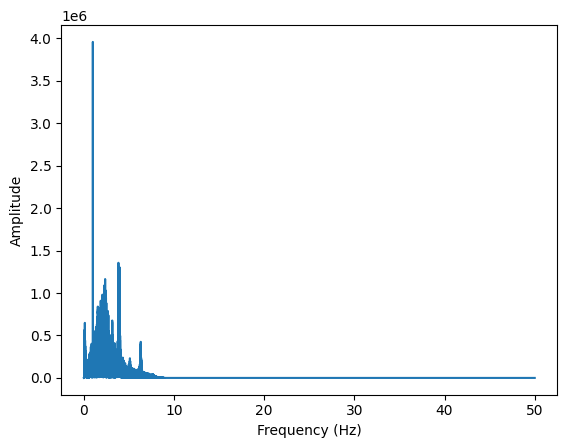

In [8]:
from scipy.fft import fft, fftfreq
import numpy as np

N = len(trace.data)
sampling_rate = trace.stats.sampling_rate
freq = fftfreq(N, d=1/sampling_rate)
fft_data = fft(trace.data)

# Plot frequency spectrum
plt.plot(freq[:N // 2], np.abs(fft_data[:N // 2]))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()


In [9]:
phase = np.angle(fft_data)

In [10]:
from scipy.signal import hilbert

analytic_signal = hilbert(trace.data)
envelope = np.abs(analytic_signal)


In [11]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

cft = classic_sta_lta(trace.data, int(5 * sampling_rate), int(10 * sampling_rate))
triggers = trigger_onset(cft, 1.5, 0.5)
print(triggers)


[[   999  29596]
 [ 34153  45410]
 [ 49569  62462]
 [ 64503  65080]
 [ 69310  70024]
 [ 87144  91354]
 [ 91850 118436]
 [120201 130499]
 [147283 156309]
 [156805 164233]
 [175680 234498]
 [260139 264708]
 [265278 273835]
 [283968 287928]]


In [12]:
min_length = min(len(timestamps), len(amplitude), len(fft_data), len(phase), len(envelope))
print(f"Minimum length: {min_length}")



Minimum length: 72000


In [13]:
timestamps = timestamps[:min_length]
amplitude = amplitude[:min_length]
frequency = np.abs(fft_data[:min_length])  # Ensure it's magnitude
phase = phase[:min_length]
envelope = envelope[:min_length]


In [14]:
import pandas as pd


features = {
    "timestamp": timestamps,
    "amplitude": amplitude,
    "frequency": frequency,
    "phase": phase,
    "envelope": envelope,
}

df = pd.DataFrame(features)
df.to_csv("seismic_features.csv", index=False)
print("Feature data saved successfully.")


Feature data saved successfully.
